# Imports

In [29]:
from __future__ import annotations

import os
import sys
from datetime import datetime
from typing import Any, Dict, Generator, List, Tuple, Union

sys.path.append('../../two-tower-ml')

import warnings

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

from utils.logger import get_logger

logger = get_logger()

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(tf.__version__, keras.__version__)

# Set the maximum number of columns to display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
tf.random.set_seed(42)

logger.info('Getting libraries and packages')

path_folder = '../ml-100k'

2.11.1 2.11.0
[INFO][2023-07-24 20:11:45,594][TwoTowerLog] - Getting libraries and packages


# Data loading

In [30]:
items = 'u.item'
ratings = 'ua.base'

movies_path = os.path.join(path_folder, items)
ratings_path = os.path.join(path_folder, ratings)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_df = pd.read_csv(movies_path, sep='|', encoding='latin-1', names=i_cols)
ratings_df = pd.read_csv(ratings_path,  sep='\t', encoding='latin-1', names=r_cols).dropna()

In [31]:
# replacing blank space for underlines in the column names
cols = [col.lower().replace(' ', '_').replace('[', '').replace(']', '') for col in movies_df.columns]
movies_df.columns = cols
movies_df.head(2)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children's,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [32]:
# forcing ids to become string instead of integers
ratings_df['user_id'] = 'id_' + ratings_df['user_id'].astype(str)
ratings_df['movie_id'] = 'id_' + ratings_df['movie_id'].astype(str)
movies_df['movie_id'] = 'id_' + movies_df['movie_id'].astype(str)

# Preprocessing

In [33]:
def hour_to_shift(timestamps):

    shift = 0

    # Determine the shift based on the hour
    if 6 <= timestamps < 10:
        shift = "Breakfast"
    elif 10 <= timestamps < 14:
        shift="Lunch"
    elif 14 <= timestamps < 18:
        shift="Afternoon"
    elif 18 <= timestamps < 22:
        shift="Dinner"
    else:
        shift="Noon"

    return shift

In [34]:
# Let's divide the users by segments. Heavy and light users. 
# The aim is to predict a batch of candidates for the light users using the heavy user's past interactions.
# light_user_ratings_df will be used as the test dataset for serving

heavy_user_df = ratings_df['user_id'].value_counts()[:600].index
light_user_df = ratings_df['user_id'].value_counts()[600:].index
heavy_user_ratings_df = ratings_df.query('user_id in @heavy_user_df')
light_user_ratings_df = ratings_df.query('user_id in @light_user_df')

In [35]:
# let's preprocess some temporal features
heavy_user_ratings_df['ordered_unix_timestamp'] = pd.to_datetime(heavy_user_ratings_df['unix_timestamp'], unit='s')
heavy_user_ratings_df['shift']=heavy_user_ratings_df['ordered_unix_timestamp'].dt.hour.apply(lambda x: hour_to_shift(x))
heavy_user_ratings_df['day_of_week']=heavy_user_ratings_df['ordered_unix_timestamp'].dt.day_name()

light_user_ratings_df['ordered_unix_timestamp'] = pd.to_datetime(light_user_ratings_df['unix_timestamp'], unit='s')
light_user_ratings_df['shift']=light_user_ratings_df['ordered_unix_timestamp'].dt.hour.apply(lambda x: hour_to_shift(x))
light_user_ratings_df['day_of_week']=light_user_ratings_df['ordered_unix_timestamp'].dt.day_name()

In [36]:
# let's split the dataset between, train/val/test

# Sort the DataFrame by user_id and unix_timestamp
heavy_user_ratings_df = heavy_user_ratings_df.sort_values(['user_id', 'ordered_unix_timestamp'])

train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

# Group the DataFrame by user_id
grouped = heavy_user_ratings_df.groupby('user_id')

# Iterate over each user group and split the data into train, validation, and test sets
for _, group in grouped:
    # Get the unique timestamps for the user
    unique_timestamps = group['ordered_unix_timestamp'].unique()
    
    # Determine the split points for train, validation, and test sets
    train_split = int(0.8 * len(unique_timestamps))
    val_split = int(0.9 * len(unique_timestamps))
    
    # Split the unique timestamps
    train_timestamps = unique_timestamps[:train_split]
    val_timestamps = unique_timestamps[train_split:val_split]
    test_timestamps = unique_timestamps[val_split:]

    # Split the data based on the timestamps
    train = group[group['ordered_unix_timestamp'].isin(train_timestamps)]
    val = group[group['ordered_unix_timestamp'].isin(val_timestamps)]
    test = group[group['ordered_unix_timestamp'].isin(test_timestamps)]
    
    # Append the split data to the respective datasets
    train_df = pd.concat([train_df, train], axis = 0)
    val_df = pd.concat([val_df,val], axis = 0)
    test_df = pd.concat([test_df, test], axis = 0)

# Print the resulting datasets
print("Train dataset:")
print(train_df.shape)
print("\nValidation dataset:")
print(val_df.shape)
print("\nTest dataset:")
print(test_df.shape)

Train dataset:
(68050, 7)

Validation dataset:
(7724, 7)

Test dataset:
(8210, 7)


In [37]:
# Now, preprocessing some features regarding the genre of the movie. 
# In this case, let's grab the first genre presented. 

genre_columns = ['unknown', 'action', 'adventure', 'animation', "children's",
       'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir',
       'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war',
       'western']

# Create the 'movie_genre' column by joining the genre names
movies_df['movie_genre'] = movies_df[genre_columns].apply(
    lambda x: ', '.join([col for col, val in zip(genre_columns, x) if val == 1]),
    axis=1
)

movies_df = pd.concat([
    movies_df,
    movies_df['movie_genre'].str.split(', ', expand=True).rename(columns={0:'genre1', 1:'genre2',2:'genre3',3:'genre4', 4:'genre5', 5:'genre5'})
],axis=1)

movies_df.head(2)


,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children's,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western,movie_genre,genre1,genre2,genre3,genre4,genre5,genre5
0,id_1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"animation, children's, comedy",animation,children's,comedy,None,None,None
1,id_2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"action, adventure, thriller",action,adventure,thriller,None,None,None


In [38]:
# preprocessing some features regarding the past consumer behavior of the movies. 
# In this case, total number of views and rating's average score

additional_features = train_df.groupby('movie_id').aggregate({'user_id':'count','rating':'mean'}).rename(columns={'user_id':'total_views', 'rating':'avg_score'}).reset_index()
additional_features['avg_score'] = additional_features['avg_score'].round(2)
additional_features

,movie_id,total_views,avg_score
0,id_1,309,3.87
1,id_10,65,3.75
2,id_100,352,4.16
3,id_1000,8,3.00
4,id_1001,14,2.00
...,...,...,...
1598,id_995,18,3.22
1599,id_996,8,2.25
1600,id_997,7,2.43
1601,id_998,6,2.33


In [39]:
# adding those additional features to the train/val/test/movie dataframes 
# There are several other features to be created (freshness, indie/popular...). 
# For the purpose of this notebook, i wanted to create variables enough for the model but not that much now

columns = [
    'movie_id',
    'movie_title',
    'movie_genre',
    'total_views',
    'avg_score', 
    'genre1',
]

movies_df = (movies_df
             .merge(additional_features,left_on='movie_id', right_on='movie_id',how = 'left')
)

train_df = (train_df
            .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
            )

val_df = (
    val_df
    .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
)

test_df = (test_df
           .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
)

light_user_ratings_df = (light_user_ratings_df
           .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
)

In [40]:
# droping no need variables

train_df = train_df.drop(['rating','ordered_unix_timestamp'],axis=1)
val_df = val_df.drop(['rating','ordered_unix_timestamp'],axis=1)
test_df = test_df.drop(['rating','ordered_unix_timestamp'],axis=1)

light_user_ratings_df = light_user_ratings_df.drop(['rating','ordered_unix_timestamp'],axis=1)

In [41]:
# convert pandas dataframe to tf dataframe

train_tf = tf.data.Dataset.from_tensor_slices(train_df.to_dict('list'))#.prefetch(2)
val_tf = tf.data.Dataset.from_tensor_slices(val_df.to_dict('list'))#.prefetch(2)
test_tf = tf.data.Dataset.from_tensor_slices(test_df.to_dict('list'))#.prefetch(2)

movies_tf = tf.data.Dataset.from_tensor_slices(dict(movies_df[columns].to_dict('list')))#.prefetch(2)

In [42]:
# convert tf dataframe to this json formated tf dataframe. 
# Format required for training the model

train = train_tf.map(lambda x: {
    "user_id": x["user_id"],
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    # "unix_timestamp": x["unix_timestamp"],
    "shift": x["shift"],
    "day_of_week": x["day_of_week"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

val = val_tf.map(lambda x: {
    "user_id": x["user_id"],
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    # "unix_timestamp": x["unix_timestamp"],
    "shift": x["shift"],
    "day_of_week": x["day_of_week"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

test = test_tf.map(lambda x: {
    "user_id": x["user_id"],
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    # "unix_timestamp": x["unix_timestamp"],
    "shift": x["shift"],
    "day_of_week": x["day_of_week"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

movies = movies_tf.map(lambda x: {
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

In [43]:
# batching the entire dataframe for memory safety

tf.random.set_seed(42)

cached_train = train.batch(1000).cache()
cached_val = val.batch(1000).cache()
cached_test = test.batch(1000).cache()

In [44]:
# Before moving to the two-tower architecture's code. 
# We need to set some variables to the model such as the input/output dimensions of the embeddings. 

user_ids = train_tf.batch(1_000).map(lambda x: x["user_id"])
movie_ids = movies_tf.batch(1_000).map(lambda x: x["movie_id"])
title_movie_ids = movies_tf.batch(1_000).map(lambda x: x["movie_title"])
genre_ids = movies_tf.batch(1_000).map(lambda x: x["genre1"])
shift_ids = train_tf.batch(1_000).map(lambda x: x["shift"])
day_of_week_ids = train_tf.batch(1_000).map(lambda x: x["day_of_week"])


# getting a list of the unique values for each variable
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_movie_ids = np.unique(np.concatenate(list(movie_ids)))
unique_title_movie_ids = np.unique(np.concatenate(list(title_movie_ids)))
unique_genre_ids = np.unique(np.concatenate(list(genre_ids)))
unique_shift_ids = np.unique(np.concatenate(list(shift_ids)))
unique_day_of_week_ids = np.unique(np.concatenate(list(day_of_week_ids)))

In [45]:
# creating buckets for numerical variables such as total views and average score. 
# There are other strategies and i encourage you to use them. 

total_views = np.concatenate(list(train_tf.map(lambda x: x["total_views"]).batch(1000)))

max_total_views = total_views.max()
min_total_views = total_views.min()

total_views_buckets = np.linspace(
    min_total_views, max_total_views, num=20, dtype = int
)

total_views_buckets

array([  1,  21,  41,  61,  82, 102, 122, 143, 163, 183, 204, 224, 244,
       265, 285, 305, 326, 346, 366, 387])

In [46]:
avg_score = np.concatenate(list(train_tf.map(lambda x: x["avg_score"]).batch(1000)))

max_avg_score = avg_score.max()
min_avg_score = avg_score.min()

avg_score_buckets = np.linspace(
    min_avg_score, max_avg_score, num=5, dtype = int
)

avg_score_buckets

array([1, 2, 3, 4, 5])

In [47]:
# avg_unix_timestamp = np.concatenate(list(train_tf.map(lambda x: x["unix_timestamp"]).batch(1000)))

# max_avg_unix_timestamp = avg_unix_timestamp.max()
# min_avg_unix_timestamp = avg_unix_timestamp.min()

# avg_unix_timestamp_buckets = np.linspace(
#     min_avg_unix_timestamp, max_avg_unix_timestamp, num=40, dtype = int
# )

# avg_unix_timestamp_buckets

# Model

In [48]:
# First tower regarding the user. 
# Please note, for serving purpose, required variable for training in this component are required for serving.
# In this case, user should be registed and a user_id should be designed, past watched movie, 
# current shift and current day of week are required for the prediction. 

# please note the input layer, the StringLookup contained, the Flatten layer

class UserModel(tf.keras.Model):
      
    def __init__(self):
        
        super().__init__()
        
        self.user_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'user_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_user_ids) + 1,
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUser')
            ])
    
        self.movie_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'movie_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_movie_ids) + 1, 
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserMovie')
        ])
        
        # day of week
        self.shift_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'shift_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_shift_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_shift_ids) + 1, 
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserShift')
            ])

        # day of hour
        self.week_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'week_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_day_of_week_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_day_of_week_ids) + 1, 
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserWeek')
            ])

    def call(self, inputs):
        
        return tf.concat([
                self.user_query_model(inputs["user_id"]),
                self.movie_query_model(inputs["movie_id"]),
                self.shift_query_model(inputs["shift"]),
                self.week_query_model(inputs["day_of_week"]),
                # self.timestamp_query_model(inputs["unix_timestamp"])
            ], axis = 1)

In [49]:
UserModel()

In [50]:
movie_title_lookup = tf.keras.layers.StringLookup()
movie_title_lookup.adapt(movies.map(lambda x: x["movie_title"]))
print(f"Vocabulary: {movie_title_lookup.get_vocabulary()[:3]}")

Vocabulary: ['[UNK]', "Ulee's Gold (1997)", 'That Darn Cat! (1997)']


In [52]:
# Second tower regarding the candidates/movies. 
# Please note, for serving purpose, required variable for training in this component are required for serving.
# In this case, movie_id, it's title, popularity by total_views and genre are required for the prediction. 

# please note the input layer, the StringLookup contained, the Flatten layer

# candidates tower
class MovieModel(tf.keras.Model):
        
    def __init__(self):
        super().__init__()

        self.movie_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'movie_id', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.genre_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'genre_id', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_genre_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_genre_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.title_text_embedding = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name='title_text', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
            tf.keras.layers.Embedding(len(movie_title_lookup.get_vocabulary())+1, 32, mask_zero=True),
            tf.keras.layers.Flatten(name='FlattenCandidatesTitle'),
    ])
        self.total_views = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'total_views_buckets_input', dtype = tf.int64),
            tf.keras.layers.Discretization(total_views_buckets.tolist()),
            tf.keras.layers.Embedding(len(total_views_buckets) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenMerchantMonthlySales')
            ])
        
    def call(self, titles):
        return tf.concat([
            self.movie_candidate_model(titles['movie_id']),
            self.title_text_embedding(titles['movie_title']),
            self.total_views(titles['total_views']),
            self.genre_candidate_model(titles['genre1']),
            ], axis = 1)

In [53]:
MovieModel()

In [54]:
class CandidatesModel(tfrs.models.Model):

    def __init__(self):

        super().__init__()

        self.query_model = tf.keras.Sequential([
            UserModel(),
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            MovieModel(),
            tf.keras.layers.Dense(32)
        ])
        
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            'movie_id': features["movie_id"],
            'shift': features["shift"],
            'day_of_week': features["day_of_week"],
        })
        
        candidates_embeddings = self.candidate_model({
            'movie_id': features["movie_id"],
            'movie_title': features["movie_title"],
            'total_views': features["total_views"],
            'genre1': features["genre1"]
        })

        return self.task(query_embeddings, candidates_embeddings)

# Train

In [56]:
candidates_model = CandidatesModel()

In [72]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7),
    tf.keras.callbacks.ModelCheckpoint(filepath='./logs/models', save_weights_only=True, save_best_only=True, save_freq="epoch",),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

candidates_model.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
)

In [58]:
start_train = True

if start_train: 
    history = candidates_model.fit(
        x=cached_train,
        epochs=30,
        verbose=True,
        batch_size=16,
        validation_data=cached_val,
        callbacks=callbacks,
        use_multiprocessing=True,
        workers=12
    )

Epoch 1/30
69/69 [==============================] - 25s 314ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0024 - factorized_top_k/top_5_categorical_accuracy: 0.0121 - factorized_top_k/top_10_categorical_accuracy: 0.0224 - factorized_top_k/top_50_categorical_accuracy: 0.0812 - factorized_top_k/top_100_categorical_accuracy: 0.1381 - loss: 6713.6974 - regularization_loss: 0.0000e+00 - total_loss: 6713.6974 - val_factorized_top_k/top_1_categorical_accuracy: 0.0047 - val_factorized_top_k/top_5_categorical_accuracy: 0.0219 - val_factorized_top_k/top_10_categorical_accuracy: 0.0408 - val_factorized_top_k/top_50_categorical_accuracy: 0.1293 - val_factorized_top_k/top_100_categorical_accuracy: 0.2175 - val_loss: 4763.9473 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4763.9473
Epoch 2/30
69/69 [==============================] - 19s 273ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0148 - factorized_top_k/top_5_categorical_accuracy: 0.0654 - factorized_top_k/top_10_

In [59]:
if start_train:
    candidates_model.save_weights(filepath='./weights/trained_n_personalized_model', overwrite=True)

# Evaluation

In [60]:
history.history['loss']

[195.33990478515625,
 194.78297424316406,
 193.22866821289062,
 189.0330352783203,
 179.8782958984375,
 166.9022674560547,
 154.52755737304688,
 143.10064697265625,
 132.91700744628906,
 124.08248901367188,
 115.63432312011719,
 106.9023666381836,
 97.77227020263672,
 88.52992248535156,
 79.59074401855469,
 71.2920913696289,
 63.78341293334961,
 57.0416374206543,
 50.95391082763672,
 45.398990631103516,
 40.304359436035156,
 35.63594055175781,
 31.363941192626953,
 27.463157653808594,
 23.92683982849121,
 20.764251708984375,
 17.985881805419922,
 15.587101936340332,
 13.541874885559082,
 11.807384490966797]

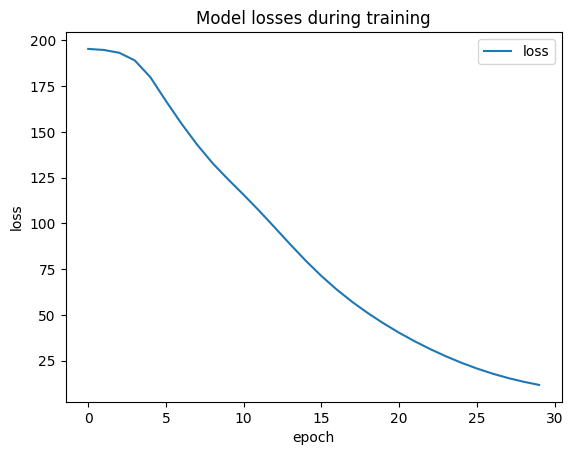

In [61]:
# Plot changes in model loss during training


if start_train:

    plt.plot(history.history["loss"])
    # plt.plot(history.history["regularization_loss"])
    # plt.plot(history.history["total_loss"])
    plt.title("Model losses during training")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["loss"], loc="upper right")
    plt.show()

In [62]:
if start_train:
    train_accuracy = candidates_model.evaluate(
        cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

    test_accuracy = candidates_model.evaluate(
        cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

    print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
    print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

9/9 [==============================] - 2s 182ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5650 - factorized_top_k/top_5_categorical_accuracy: 0.9348 - factorized_top_k/top_10_categorical_accuracy: 0.9518 - factorized_top_k/top_50_categorical_accuracy: 0.9784 - factorized_top_k/top_100_categorical_accuracy: 0.9843 - loss: 1737.5487 - regularization_loss: 0.0000e+00 - total_loss: 1737.5487
Top-100 accuracy (train): 1.00.
Top-100 accuracy (test): 0.98.


# Serving

In [63]:
candidates_model.load_weights(filepath='./weights/trained_n_personalized_model')

In [64]:
# recommends 100 movies out of the entire merchant dataset.

index = tfrs.layers.factorized_top_k.ScaNN(
    distance_measure = 'dot_product',
    num_leaves = 100,
    num_leaves_to_search = 10,
    training_iterations = 12,
    dimensions_per_block = 2,
    parallelize_batch_searches = True,
    query_model=candidates_model.query_model,
    k = 100
)


In [65]:
trained_index = index.index_from_dataset(
  tf.data.Dataset.zip((
    movies.batch(100).map(lambda x: x["movie_id"]), 
    movies.batch(100).map(lambda x: {
      'movie_id':x["movie_id"],
      'total_views':x["total_views"],
      'movie_title':x["movie_title"],
      'genre1':x["genre1"],
      }).map(candidates_model.candidate_model)))
)

In [66]:
# Input date in the format "12/12/2022"
date_str = "01/16/1998"

# Convert the date string to a datetime object
date_obj = datetime.strptime(date_str, "%m/%d/%Y")

# Convert the datetime object to a Unix timestamp
unix_timestamp = int(date_obj.timestamp())
# Extract the day of the week
day_of_week = date_obj.strftime("%A")

print(f'date_obj:{date_obj}')
print("Unix Timestamp:", unix_timestamp)
print(f"day of week:", day_of_week)

date_obj:1998-01-16 00:00:00
Unix Timestamp: 884908800
day of week: Friday


In [67]:
light_user_ratings_df['ordered_unix_timestamp'] = pd.to_datetime(light_user_ratings_df['unix_timestamp'], unit='s')
light_user_ratings_df = light_user_ratings_df.sort_values(['user_id', 'ordered_unix_timestamp'])

light_user_ratings_df

,user_id,movie_id,unix_timestamp,shift,day_of_week,movie_title,movie_genre,total_views,avg_score,genre1,ordered_unix_timestamp
583,id_103,id_181,880415875,Noon,Monday,Return of the Jedi (1983),"action, adventure, romance, sci-fi, war",366.0,4.00,action,1997-11-24 23:57:55
590,id_103,id_257,880415892,Noon,Monday,Men in Black (1997),"action, adventure, comedy, sci-fi",194.0,3.76,action,1997-11-24 23:58:12
587,id_103,id_250,880415918,Noon,Monday,"Fifth Element, The (1997)","action, sci-fi",137.0,3.50,action,1997-11-24 23:58:38
589,id_103,id_255,880416423,Noon,Tuesday,My Best Friend's Wedding (1997),"comedy, romance",94.0,3.32,comedy,1997-11-25 00:07:03
593,id_103,id_405,880416424,Noon,Tuesday,Mission: Impossible (1996),"action, adventure, mystery",241.0,3.30,action,1997-11-25 00:07:04
...,...,...,...,...,...,...,...,...,...,...,...
567,id_98,id_210,880498968,Noon,Tuesday,Indiana Jones and the Last Crusade (1989),"action, adventure",256.0,3.96,action,1997-11-25 23:02:48
572,id_98,id_502,880499053,Noon,Tuesday,Bananas (1971),"comedy, war",41.0,3.78,comedy,1997-11-25 23:04:13
562,id_98,id_88,880499087,Noon,Tuesday,Sleepless in Seattle (1993),"comedy, romance",145.0,3.51,comedy,1997-11-25 23:04:47
561,id_98,id_25,880499111,Noon,Tuesday,"Birdcage, The (1996)",comedy,207.0,3.38,comedy,1997-11-25 23:05:11


In [68]:
index_movie = dict(movies_df[['movie_id','movie_title']].to_numpy())
index_movie

{'id_1': 'Toy Story (1995)',
 'id_2': 'GoldenEye (1995)',
 'id_3': 'Four Rooms (1995)',
 'id_4': 'Get Shorty (1995)',
 'id_5': 'Copycat (1995)',
 'id_6': 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'id_7': 'Twelve Monkeys (1995)',
 'id_8': 'Babe (1995)',
 'id_9': 'Dead Man Walking (1995)',
 'id_10': 'Richard III (1995)',
 'id_11': 'Seven (Se7en) (1995)',
 'id_12': 'Usual Suspects, The (1995)',
 'id_13': 'Mighty Aphrodite (1995)',
 'id_14': 'Postino, Il (1994)',
 'id_15': "Mr. Holland's Opus (1995)",
 'id_16': 'French Twist (Gazon maudit) (1995)',
 'id_17': 'From Dusk Till Dawn (1996)',
 'id_18': 'White Balloon, The (1995)',
 'id_19': "Antonia's Line (1995)",
 'id_20': 'Angels and Insects (1995)',
 'id_21': 'Muppet Treasure Island (1996)',
 'id_22': 'Braveheart (1995)',
 'id_23': 'Taxi Driver (1976)',
 'id_24': 'Rumble in the Bronx (1995)',
 'id_25': 'Birdcage, The (1996)',
 'id_26': 'Brothers McMullen, The (1995)',
 'id_27': 'Bad Boys (1995)',
 'id_28': 'Apollo 13 (1995)',

In [69]:
# single user test
scores , titles = trained_index(queries = {
    'user_id':tf.constant(['id_103']),
    'movie_id':tf.constant(['id_181']),
    'shift':tf.constant(['Noon']),
    'day_of_week':tf.constant(['Monday']),
    }, k = 50
)


print("Recommendations for user id_103 who watched the movie Return of the Jedi (1983)")

titles = [index_movie[idx.decode('utf-8')] for idx in titles[0, :].numpy()]
dict(zip(titles, scores.numpy()[0]))

Recommendations for user id_103 who watched the movie Return of the Jedi (1983)


{'Return of the Jedi (1983)': 102.69507,
 'Alien (1979)': 100.03257,
 'Star Trek IV: The Voyage Home (1986)': 99.82457,
 'Mars Attacks! (1996)': 99.57496,
 'Hunt for Red October, The (1990)': 98.61812,
 'Aliens (1986)': 98.28532,
 'Independence Day (ID4) (1996)': 97.7445,
 'True Lies (1994)': 97.61968,
 'Heat (1995)': 96.99567,
 'Long Kiss Goodnight, The (1996)': 96.66286,
 'Time to Kill, A (1996)': 96.57966,
 'Die Hard: With a Vengeance (1995)': 95.91403,
 'Eraser (1996)': 95.78923,
 'Butch Cassidy and the Sundance Kid (1969)': 95.49802,
 'Sound of Music, The (1965)': 95.33161,
 'Air Force One (1997)': 95.20681,
 'Godfather: Part II, The (1974)': 94.08991,
 'Apollo 13 (1995)': 93.925545,
 'Broken Arrow (1996)': 93.33474,
 'Full Metal Jacket (1987)': 93.08513,
 'Abyss, The (1989)': 92.75232,
 'Princess Bride, The (1987)': 92.6359,
 "Jackie Chan's First Strike (1996)": 92.54431,
 'Godfather, The (1972)': 91.96188,
 'Glory (1989)': 91.92028,
 'Titanic (1997)': 91.71863,
 'Top Gun (1986)'

In [70]:
# now let's evaluate for the entire dataset for light_users
# the function bellow generates 100 candidates for each row and measure if the watched movie is in the batch 
# of candidates. True for Yes and False for No. Then, it is summed up and  

def predict( 
    user_id:str, 
    movie_id:str,
    shift:str,
    day_of_week:str
):

    scores, titles = index(
        {
        'user_id':tf.constant([user_id]),
        'movie_id':tf.constant([movie_id]),
        'day_of_week':tf.constant([day_of_week]),
        'shift':tf.constant([shift]),
        },k = 100
    )

    if movie_id in titles[0]:
        # print(True)
        del titles
        return True
    else:
        del titles
        # print(False)
        return False

In [71]:
# According to the results bellow, 90~94% of the interactions are covered by the candidates generation generated by
# the enricheded two-tower model. 

filtered_df = light_user_ratings_df[['user_id','movie_id', 'day_of_week', 'shift']]

df_evaluation = np.vstack(map(predict, 
    filtered_df['user_id'],
    filtered_df['movie_id'],
    filtered_df['day_of_week'],
    filtered_df['shift'],
    ))

final_df = pd.DataFrame(df_evaluation, index = filtered_df.index).rename(columns = {0:'score'})

final_df[final_df.score==True].shape[0]/final_df.shape[0]

0.9272699665958093